In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.integrate import quad
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from functools import lru_cache

In [2]:
from typing import Any, Iterable, Optional

In [3]:
from NACA_63210 import airfoil_surface
from Lift_diagrams import chord, V_distribution, M_distribution, T_distribution, dynamic_p

In [4]:
b2 = 16.07/2
root_c = 2.46 
tip_c = 1.11
E = 68.9 * 10 ** 9
G = 26 * 10 ** 9
v = 0.33
UTS = 290 * 10 ** 6
YieldStregth = 240 * 10 ** 6
rho_al = 2700
y = np.linspace(0, b2, 800)
rho_FL330 = 0.418501741
q_crit = dynamic_p(rho_FL330, 250.18)
CL_crit = 0.514 * 1.5

In [5]:
def interp_on_domain(range_object):
    def wrapper(func):
        @lru_cache(maxsize=None)
        def make_interp1d(*args, **kwargs):     
            return interp1d(range_object, func(range_object, *args, **kwargs), 
                            kind='cubic', fill_value='extrapolate')
            
        def return_func(y, *args, **kwargs):
            interpreted_func = make_interp1d(*args, **kwargs)
            return interpreted_func(y)

        return return_func

    return wrapper

In [6]:
class Panel:
    def __init__(self, point1, point2, thickness, span=b2):
        """point1 and point2 are coordinates relative to the chord, thickness in mm"""
        if point1[1] > point2[1]: # make sure point2 has the highest z coordinate
            point1, point2 = point2, point1
        self.p1 = point1
        self.p2 = point2
        self.vector = point2 - point1
        self.centre = (point1 + self.vector/2)
        self.h = LA.norm(self.vector)
        self.t = thickness
        # z is the vertical distance from the x axis relative to chord
        self.z = (point1 + self.vector/2)[1]
        self.span = span

    def l(self, y):
        return self.h * chord(y) * (y <= self.span)

    def A(self, y):
        return self.h * chord(y) * self.t(y) * (y <= self.span)
    
    def Q_x(self, y):
        """Returns first moment of area about z=0"""
        return self.centre[1] * chord(y) * self.A(y) * (y <= self.span)

    def Q_z(self, y):
        """Returns first moment of area about x=0"""
        return self.centre[0] * chord(y) * self.A(y) * (y <= self.span)
    
    def I_xc(self, y):
        """Returns second moment of area about own centroid"""
        cos_a = self.vector[0] / self.h
        sin_a = self.vector[1] / self.h

        return (self.t(y) * (self.h*chord(y)) * (self.t(y)**2 * cos_a**2 
            + (self.h*chord(y))**2 * sin_a**2) / 12 * (y <= self.span))
    
    def I_xx(self, y, z_centroid):
        """Returns second moment of area about centroid"""
        d = self.centre[1] * chord(y) - z_centroid
        return self.I_xc(y) + self.A(y) * d**2 * (y <= self.span)
    
    def z_at_x(self, x):
        if self.vector[0] == 0:
            raise ValueError("Horizontal plate does not have a heigh as a function of x")
        return (x - self.p1[0])/self.vector[0] * self.vector[1] + self.p1[1]


In [7]:
class Stringer:
    def __init__(self, area, x, length, upper: bool=True):
        """area is in square mm, point is the coordinate realtive to the chord and length is the spanwise length of the stringer"""
        self.upper = upper
        self.A = area * 1e-6
        self.point = np.array([x, 0])
        self.length = length

    @property
    def x(self):
        return self.point[0]
    
    @property
    def z(self):
        return self.point[1]
    
    @z.setter
    def z(self, new_z):
        self.point[1] = new_z
    
    def Q_x(self, y):
        """Returns first moment of area about z=0"""
        return self.A * self.point[1] * chord(y) * (self.length >= y)

    def Q_z(self, y):
        """Returns first moment of area about x=0"""
        return self.A * self.point[0] * chord(y) * (self.length >= y)

    def I_xx(self, y, z_centroid):
        """Returns second moment of area about centroid"""
        return self.A * (self.point[1] * chord(y) - z_centroid)**2  * (self.length >= y)


In [8]:
class t:
    def __init__(self, start_thickness, end_thicnkess=None, length=b2) -> None:
        if start_thickness < 0 or end_thicnkess < 0:
            raise ValueError('Cannot have negative thicknesses')
        self.t1 = start_thickness * 1e-3
        if end_thicnkess is not None:
            self.t2 = end_thicnkess * 1e-3
        else:
            self.t2 = end_thicnkess
        self.length = length

    def __eq__(self, other):
        if type(self) is not type(other):
            return False
        else:
            return self.t1 == other.t1 and self.t2 == other.t2 and self.length == other.length
    
    def __repr__(self) -> str:
        if self.t2 is None:
            return f'Constant thickness of {self.t1 * 1e3} mm over a length of {self.length} m.'
        else:
            return (f'Linear varying thickness of {self.t1 * 1e3} mm to {self.t2 * 1e3} mm' 
                    + f' over a length of {self.length} m.')

    def __call__(self, y):
        return self.t1 - (self.t1-self.t2)/self.length * y * (self.length >= y)

    def __mul__(self, other):
        t1 = self.t1 * other * 1e3
        if self.t2 is not None:
            t2 = self.t2 * other * 1e3
        else:
            t2 = None
        return self.__class__(t1, t2, self.length)

    def __truediv__(self, other):
        return self.__mul__(1/other)

    def __add__(self, other):
        t1 = self.t1 * 1e3 + other
        if self.t2 is not None:
            t2 = self.t2 * 1e3 + other
        else:
            t2 = None
        return self.__class__(t1, t2, self.length)
    
    def __sub__(self, other):
        return self.__add__(-other)


In [145]:
class WingBox:
  Kc_lim = 4

  def __init__(self, front_spar_x, front_spar_t, rear_spar_x, rear_spar_t, 
    upper_panel_t, lower_panel_t, stringers: Optional[Iterable[Stringer]]=None, 
    middle_spar_x=None, middle_spar_t=None, middle_spar_span=b2,
    ribs=[0, b2]):
    
    if middle_spar_x is None:
      self.single_cell = True
    else:
      self.single_cell = False
    # Define points of the corners of the wingbox
    front_upper_z, front_lower_z = airfoil_surface(front_spar_x)
    front_upper = np.array([front_spar_x, front_upper_z]) 
    front_lower = np.array([front_spar_x, front_lower_z])
    rear_upper_z, rear_lower_z = airfoil_surface(rear_spar_x)
    rear_upper = np.array([rear_spar_x, rear_upper_z])
    rear_lower = np.array([rear_spar_x, rear_lower_z])

    self.points = {'front_upper':front_upper, 'front_lower':front_lower, 
      'rear_upper':rear_upper, 'rear_lower':rear_lower}

    if not self.single_cell:
      # Add extra points if there is a middle spar
      middle_upper_z, middle_lower_z = airfoil_surface(middle_spar_x)
      middle_upper = np.array([middle_spar_x, middle_upper_z])
      middle_lower = np.array([middle_spar_x, middle_lower_z])
      self.points['middle_upper'] = middle_upper
      self.points['middle_lower'] = middle_lower

    self.panels = {}
    front_spar = Panel(front_lower, front_upper, front_spar_t)
    rear_spar = Panel(rear_lower, rear_upper, rear_spar_t)

    if self.single_cell:
      upper_panel = Panel(front_upper, rear_upper, upper_panel_t)
      lower_panel = Panel(front_lower, rear_lower, lower_panel_t)
      self.panels = {'front_spar':front_spar, 'rear_spar':rear_spar, 
        'upper_panel':upper_panel, 'lower_panel':lower_panel} 
    else:
      upper_panel_1 = Panel(front_upper, middle_upper, upper_panel_t)
      upper_panel_2 = Panel(middle_upper, rear_upper, upper_panel_t)
      lower_panel_1 = Panel(front_lower, middle_lower, lower_panel_t)
      lower_panel_2 = Panel(middle_lower, rear_lower, lower_panel_t)
      middle_spar = Panel(middle_lower, middle_upper, middle_spar_t, middle_spar_span)
      self.panels = {'front_spar':front_spar, 'rear_spar':rear_spar, 
        'upper_panel_1':upper_panel_1, 'upper_panel_2':upper_panel_2, 
        'lower_panel_1':lower_panel_1, 'lower_panel_2':lower_panel_2,
        'middle_spar':middle_spar}
      # Add extra lists so the two cells can be accesed seperately
      self.left_panels = {'front_spar':front_spar, 'upper_panel_1':upper_panel_1, 
        'lower_panel_1':lower_panel_1, 'middle_spar':middle_spar}
      self.right_panels = {'rear_spar':rear_spar, 'upper_panel_2':upper_panel_2, 
        'lower_panel_2':lower_panel_2, 'middle_spar':middle_spar}
      
    if stringers is not None:
      for stringer in stringers:
        panel = self.find_panel(stringer.x, stringer.upper)
        z = panel.z_at_x(stringer.x)
        stringer.z = z
    
    self.stringers = stringers
    self.ribs = ribs

  def find_panel(self, x, upper: bool):
    if upper:
      key = 'upper'
    else:
      key = 'lower'
    if self.single_cell:
      return self.panels[key+'_panel']
    else:
      middle_x = self.panels['middle_spar'].p1[0]
      if x == middle_x:
        raise ValueError('This is the location of the middle spar')
      if x < middle_x:
        return self.panels[key+'_panel_1']
      else:
        return self.panels[key+'_panel_2']
  
  def A(self, y):
    """Returns the area of the matrial of a cross sectio at a given location of span"""
    A = 0
    for panel in self.panels.values():
      A += panel.A(y)
    
    if self.stringers is not None:
      for stringer in self.stringers:
          A += stringer.A
    return A
  
  def z_centroid(self, y):
    """Returns the z-coordinate of the centroid at a given location of span"""
    A = self.A(y)
    Az = 0

    for panel in self.panels.values():
      Az += panel.Q_x(y)
    if self.stringers is not None:
      for stringer in self.stringers:
        Az += stringer.Q_x(y)

    return Az / A

  def x_centroid(self, y):
    """Returns the z-coordinate of the centroid at a given location of span"""
    A = self.A(y)
    Ax = 0

    for panel in self.panels.values():
      Ax += panel.Q_z(y)
    if self.stringers is not None:
      for stringer in self.stringers:
        Ax += stringer.Q_z(y)

    return Ax / A

  def stringer_discontinuities(self):
    lst = []
    for stringer in self.stringers:
      if stringer.length != b2:
        lst.append(stringer.length)
      return lst
  
  def w(self, y):
    """Returns dW/dy, the weight distribution of the wing"""
    return self.A(y)*rho_al

  @property
  def W(self):
    """Returns the total weight of two wingboxes"""
    return quad(self.w, 0, b2)[0] * 2

  def I_xx(self, y):
    """Returns the moment of inertia about the centroid of the wingbox"""
    c = chord(y)
    z_centroid = self.z_centroid(y)
    I_xx = 0

    for panel in self.panels.values():
      I_xx += panel.I_xx(y, z_centroid)

    if self.stringers is not None:
      for stringer in self.stringers:
        I_xx += stringer.I_xx(y, z_centroid) * (stringer.length >= y)

    return I_xx
  
  def J_single_cell(self, y):
    # Calculate area inside box
    width = self.points["rear_upper"][0] - self.points["front_upper"][0]
    A = width/2*(self.panels["front_spar"].h + self.panels["rear_spar"].h) * chord(y)**2
    integral = 0
    for panel in self.panels.values():
      integral += panel.h * chord(y)/panel.t(y)
    return 4 * A**2 / integral
    
  def J_multi_cell(self, y):
    panels = self.panels
    width_1 = self.points["middle_upper"][0] - self.points["front_upper"][0]
    width_2 = self.points["rear_upper"][0] - self.points["middle_upper"][0]
    A_1 = width_1/2*(panels["front_spar"].h + panels["middle_spar"].h) * chord(y)**2
    A_2 = width_1/2*(panels["rear_spar"].h + panels["middle_spar"].h) * chord(y)**2
    # a * q1 + b * q2 - dthetadx = 0
    # c * q1 + d * q2 - dthetadx = 0
    # e * q1 + f * q2 - 0 = T
    # q1 is shear flow in left box, q2 shear flow in the right box
    a = 0
    for panel in self.left_panels.values():
      a += panel.l(y)/panel.t(y)
    a *= 1/(2*A_1*G)
    b = -panels['middle_spar'].l(y)/panels['middle_spar'].t(y) /(2*A_1*G)

    d = 0
    for panel in self.right_panels.values():
      d += panel.l(y)/panel.t(y)
    d *= 1/(2*A_2*G)
    c = -panels['middle_spar'].l(y)/panels['middle_spar'].t(y) /(2*A_2*G)

    e = 2*A_1
    f = 2*A_2
    T = 1
    system = np.array([[a, b, np.broadcast_to(-1, np.shape(a))],
                       [c, d, np.broadcast_to(-1, np.shape(a))],
                       [e, f, np.broadcast_to(0, np.shape(a))]])
    
    if system.ndim > 2:
      system = np.moveaxis(system, 2, 0)
      N, M, M = np.shape(system)
      righthandside = np.broadcast_to(np.array([0, 0, T]), (N, M))
      q1, q2, dthetadx = np.swapaxes(LA.solve(system, righthandside), 0, 1)
    else:
      q1, q2, dthetadx = LA.solve(system, np.array([0, 0, T]))

    J = T/(G*dthetadx)
    return J
    
  def J(self, y):
    """Returns the torsional stiffness of the wingbox"""
    if self.single_cell:
      return self.J_single_cell(y)
    else:
      return self.J_multi_cell(y)

  def check_skin_buckling(self):
    # if there are n ribs, there should be n sections that need to be checked (assuming no rib at tip)
    # loop over each section, each section has rib1, and rib2
    #
    # the stringers that are considered to be on the top panel are the ones with positive z coordinate
    # sigma_cr is evaluated at rib2, sigma_max is evaluated at both rib1 and rib2 and the highest is selected
    # 
    # for stringer in self.stringers:
    #   
    # sigma_cr
    # take t at rib2
    # a is the distance between rib1 and rib2, don't think a is used in calculation if Kc is taken constant
    
    # loop over sections between ribs
    rib1 = self.ribs[0]
    for rib2 in self.ribs[1:]:
      y1, y2 = rib1, rib2
      chord1, chord2 = chord(y1), chord(y2)
      I_xx1, I_xx2 = self.I_xx(y1), self.I_xx(y2)
      M1, M2 = M(y1), M(y2)
      
      section_points = [self.panels['front_spar'].p2, self.panels['rear_spar'].p2]
      if not self.single_cell:
        section_points.append(self.points['middle_spar'].p2)
      if self.stringers is not None:
        for stringer in self.stringers:
          if stringer.upper:
            if stringer.length > y2:
              section_points.append(stringer.point)
      section_points.sort(key=lambda elem: elem[0])
      
      # loop over sections between stringers
      point1 = section_points[0]
      for point2 in section_points[1:]:
        b = LA.norm(point2 - point1) * chord2
        x = (point1[0]+point2[0])/2
        t2 = self.find_panel(x, True).t(y2)
        sigma_crit = np.pi**2 * self.Kc_lim * E / (12*(1-v**2)) * (t2/b)**2

        z_max = max(point1[1], point2[1])
        z1_max, z2_max = z_max*chord1, z_max*chord2
        sigma1_max = z1_max*M1/I_xx1
        sigma2_max = z2_max*M2/I_xx2
        sigma_max = max(sigma1_max, sigma2_max)

        print(f'ribs at {rib1} and {rib2} m span')
        print(f'section between {point1} and {point2}')
        print(f"Sigma crit = {sigma_crit:2.2}")
        print(f"Sigma 1 max = {sigma1_max:2.2}")
        print(f"Sigma 2 max = {sigma2_max:2.2}")

        point1 = point2

      rib1 = rib2

  
  def plot(self):
    c = chord(0)
    x = np.linspace(0, 1, 100)
    plt.plot(x, airfoil_surface(x)[0], color='grey', linewidth=1)
    plt.plot(x, airfoil_surface(x)[1], color='grey', linewidth=1)
    plt.scatter(self.x_centroid(0)/c, self.z_centroid(0)/c)
    for panel in self.panels.values():
      if panel.vector[0] != 0:
        x = np.linspace(panel.p1[0], panel.p2[0], 100)
        plt.plot(x, panel.z_at_x(x), color='black', linewidth=3)
      else:
        x = panel.p1[0]
        z = np.linspace(panel.p1[1], panel.p2[1], 100)
        plt.plot(np.full(100, x), z, color='black', linewidth=3)
      # plt.xlim((0.13, 0.62))
      plt.gca().set_aspect('equal', adjustable='box')
      plt.gcf().set_size_inches(15, 15)
      plt.gcf().set_dpi(200)
      # plt.gca().axis('off')
      # plt.gca().get_xaxis().set_visible(False)
      # plt.gca().get_yaxis().set_visible(False)
      # 

  def plot_max_stress(self):
    c = chord(0)
    x = np.linspace(0, 1, 100)
    panels = [self.panels['front_spar'], self.panels['rear_spar']]
    if not self.single_cell:
      panels.append(self.panels['middle_spar'])
    z_max = max([panel.p2[1] for panel in panels])
    z_min = min([panel.p1[1] for panel in panels])
    # print(z_max)
    z_c = self.z_centroid(y)
    # print(z_c)
    I_xx = self.I_xx(y)
    stress_lower = M(y) * (z_min * chord(y) - z_c) / I_xx
    stress_upper = M(y) * (z_max * chord(y) - z_c) / I_xx
    plt.plot(y, stress_lower, label='$\sigma$ lower panel')
    plt.plot(y, stress_upper, label='$\sigma$ upper panel')
    plt.legend()

In [106]:
a = [np.array((1,2)), np.array((3, 4))]
b = [i for i in a]
max(b)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [11]:
V = V_distribution(CL_crit, q_crit)
M = M_distribution(V)

DISPLACEMENT

In [12]:
@interp_on_domain(y)
def d2zdx2(y, wingbox: WingBox):
    """calculate second derivative of the displacement"""
    return -(M(y)/E/wingbox.I_xx(y))


@interp_on_domain(y)
def dzdx(y, wingbox: WingBox):
    """calculate first derivative through integration"""
    quad_vec = np.vectorize(quad)
    return quad_vec(d2zdx2, 0, y, args=(wingbox))[0]
    

def z(y, wingbox: WingBox):
    """calculate displacement through integration"""
    quad_vec = np.vectorize(quad)
    return quad_vec(dzdx, 0, y, args=(wingbox))[0]

zperc = lambda y: z(y, wingbox_iteration_1) / b2 * 50

ROTATION

In [13]:
@interp_on_domain(y)
def dthetadx(y, wingbox: WingBox):
    """calculate first derivative of the rotation"""
    T = T_distribution(CL_crit, q_crit, wingbox)
    return T(y)/wingbox.J(y)/G

def theta(y, wingbox: WingBox):
    """calculate rotation through integration"""
    y_range = np.linspace(0, b2, 800)
    func = interp1d(y_range, dthetadx(y, wingbox), kind='cubic', fill_value='extrapolate')
    return [quad(func, 0, i)[0] * 180 / np.pi for i in y]
    

In [138]:
t_5 = t(5, 5)
t_3 = t(3, 3)
t_2 = t(2, 2)
t_1 = t(1, 1)
stringer_u1 = Stringer(50, 0.3, 1)
stringer_u2 = Stringer(50, 0.4, 1)
stringer_u3 = Stringer(50, 0.5, 1)
stringer_l1 = Stringer(50, 0.4, 1)
stringers = [stringer_u1, stringer_u2, stringer_u3, stringer_l1]
stringers = stringers + stringers + stringers
stringers = stringers + stringers + stringers

wingbox_iteration_1_stringer = WingBox(0.2, t_5, 0.6, t_5, t_5, t_5, stringers=stringers, ribs=[0, 1, 2, 3, b2])

wingbox_iteration_1 = WingBox(0.2, t(25, 3), 0.6, t(25, 3), t(25, 3), t(25, 3), ribs=[0, 1, 2, 3, 4, 5, 6, 7, b2])
wingbox_iteration_2 = WingBox(0.2, t(2,1), 0.6, t(2,1), t(3,1), t(3,1))

In [146]:
wingbox_iteration_4 = WingBox(0.15, t(3,2), 0.6, t(3,2), t(6,1), t(6,1), stringers=stringers, middle_spar_x=0.37, middle_spar_t=t(3,2))


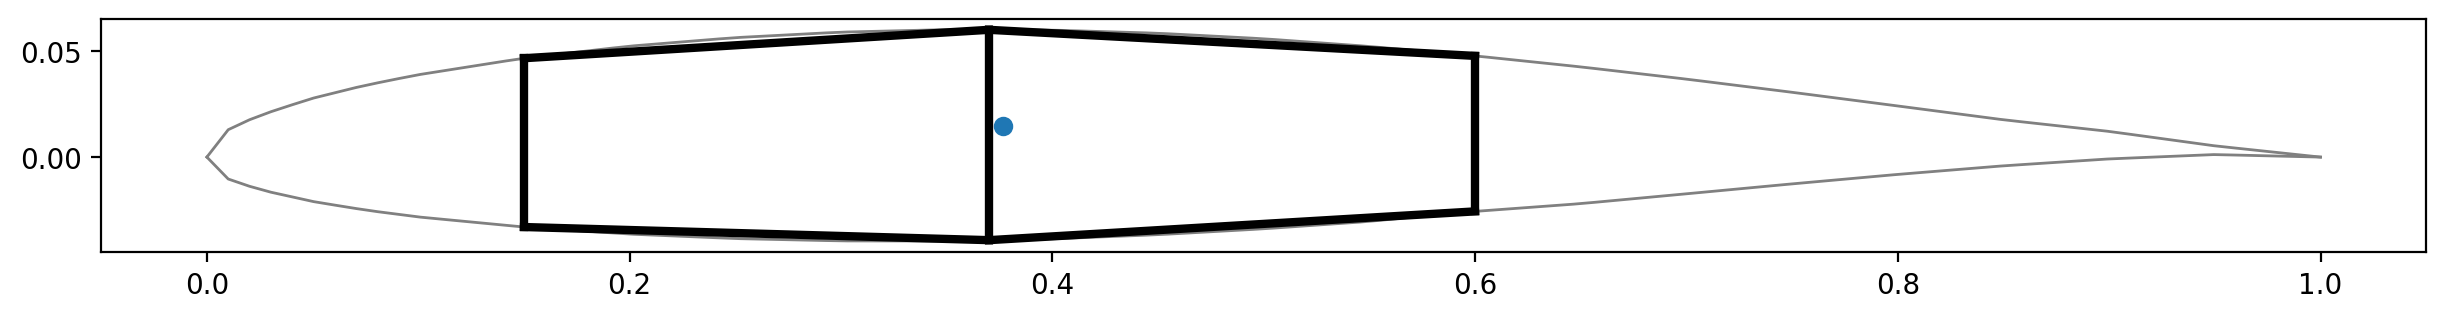

In [153]:
wingbox_iteration_4.plot()

In [124]:
wingbox_iteration_4.z_centroid(0)/chord(0)

0.012997199200984837

In [50]:
WingBox(0.15, t_5, 0.6, t_5, t_5, t_5, middle_spar_x=0.37, middle_spar_t=t_5).I_xx(0), WingBox(0.15, t_5, 0.6, t_5, t_5, t_5).I_xx(0)

(0.00014282644332974849, 0.0001044321055116714)

In [17]:
wingbox_iteration_1_stringer.check_skin_buckling()

ribs at 0 and 1 m span
section between [0.2        0.05247953] and [0.3        0.05133003]
Sigma crit = 1.2e+08
Sigma 1 max = -6.1e+08
Sigma 2 max = -5.1e+08
ribs at 0 and 1 m span
section between [0.3        0.05133003] and [0.4        0.05018052]
Sigma crit = 1.2e+08
Sigma 1 max = -5.9e+08
Sigma 2 max = -5e+08
ribs at 0 and 1 m span
section between [0.4        0.05018052] and [0.6       0.0478815]
Sigma crit = 3e+07
Sigma 1 max = -5.8e+08
Sigma 2 max = -4.9e+08
ribs at 1 and 2 m span
section between [0.2        0.05247953] and [0.3        0.05133003]
Sigma crit = 1.4e+08
Sigma 1 max = -5.1e+08
Sigma 2 max = -4.2e+08
ribs at 1 and 2 m span
section between [0.3        0.05133003] and [0.4        0.05018052]
Sigma crit = 1.4e+08
Sigma 1 max = -5e+08
Sigma 2 max = -4.1e+08
ribs at 1 and 2 m span
section between [0.4        0.05018052] and [0.6       0.0478815]
Sigma crit = 3.5e+07
Sigma 1 max = -4.9e+08
Sigma 2 max = -4e+08
ribs at 2 and 3 m span
section between [0.2        0.05247953] a

-3.51e+08


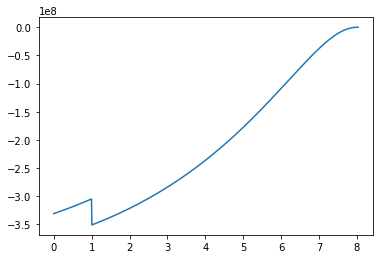

In [139]:
stress = M(y) * chord(y) * 0.05 / wingbox_iteration_4.I_xx(y)
plt.plot(y, stress)
print(f'{min(stress):.4}')

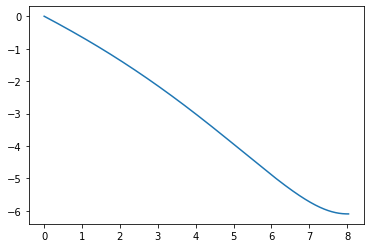

In [152]:
plt.plot(y, theta(y, wingbox_iteration_4))

0.06021423360574048
[0.03614598 0.0361392  0.03613243 0.03612568 0.03611894 0.03611221
 0.0361055  0.0360988  0.03609212 0.03608545 0.03607879 0.03607215
 0.03606553 0.03605891 0.03605232 0.03604573 0.03603917 0.03603261
 0.03602607 0.03601955 0.03601304 0.03600654 0.03600006 0.03599359
 0.03598714 0.03598071 0.03597428 0.03596788 0.03596149 0.03595511
 0.03594875 0.0359424  0.03593606 0.03592975 0.03592344 0.03591716
 0.03591088 0.03590463 0.03589838 0.03589216 0.03588595 0.03587975
 0.03587357 0.0358674  0.03586125 0.03585512 0.035849   0.03584289
 0.0358368  0.03583073 0.03582467 0.03581863 0.0358126  0.03580659
 0.03580059 0.03579461 0.03578865 0.0357827  0.03577677 0.03577085
 0.03576495 0.03575906 0.03575319 0.03574734 0.0357415  0.03573568
 0.03572987 0.03572408 0.03571831 0.03571255 0.03570681 0.03570109
 0.03569538 0.03568969 0.03568401 0.03567835 0.03567271 0.03566708
 0.03566147 0.03565587 0.0356503  0.03564473 0.03563919 0.03563366
 0.03562815 0.03562265 0.03561718 0.035611

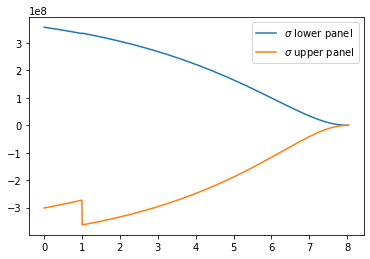

In [154]:
wingbox_iteration_4.plot_max_stress()

In [21]:
V(0)*2/9.81/3.09/1.5

6373.675941896025